In [5]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [6]:
dfOriginal=pd.read_csv("..\\20180821_Tatvam_Export.csv")
df=dfOriginal.loc[dfOriginal["Review Comment"].isnull()==False]
df.head()

,Unique ID,Review Title,Review Comment,Tatvam Rating,User Rating,Source Name,Review URL,Date,Name,Customer,Parent Value,Value,Tag Tatvam Rating,Review Month
4216,5238258,NaN,Overpriced !!!!!!!,1,1,Google Reviews,https://www.google.co.in/maps/place/Georgia+Aq...,"Wednesday, January 10, 2018",Jim Glekas,Georgia Aquarium,NaN,NaN,NaN,January
4217,5264943,NaN,If you are a police officer dont think you can...,1,1,Google Reviews,https://www.google.co.in/maps/place/Georgia+Aq...,"Wednesday, January 17, 2018",Mallory brabham,Georgia Aquarium,Staff,Staff,1.0,January
4218,5383360,NaN,"the whale shark looked retarded, fishes wouldn...",1,1,Google Reviews,https://www.google.co.in/maps/place/Georgia+Aq...,"Wednesday, January 17, 2018",hot chito,Georgia Aquarium,Ocean Voyager,Whale Sharks,3.0,January
4219,5383380,NaN,"It's like a zoo for people, rather than fish. ...",1,1,Google Reviews,https://www.google.co.in/maps/place/Georgia+Aq...,"Wednesday, January 24, 2018",Seth Manzano-Flores,Georgia Aquarium,Aquarium,Aquarium,2.0,January
4220,5383380,NaN,"It's like a zoo for people, rather than fish. ...",1,1,Google Reviews,https://www.google.co.in/maps/place/Georgia+Aq...,"Wednesday, January 24, 2018",Seth Manzano-Flores,Georgia Aquarium,Crowd,Crowd,1.0,January


In [8]:
data=df["Review Comment"].tolist()
data[:3]

['Overpriced !!!!!!!',
 'If you are a police officer dont think you can bring your fire arm into the aquirium. They have no security office (makes you feel safe, right?). The customer service manager is RUDE.',
 "the whale shark looked retarded, fishes wouldn't wave back #lame"]

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['overpriced'], ['if', 'you', 'are', 'police', 'officer', 'dont', 'think', 'you', 'can', 'bring', 'your', 'fire', 'arm', 'into', 'the', 'aquirium', 'they', 'have', 'no', 'security', 'office', 'makes', 'you', 'feel', 'safe', 'right', 'the', 'customer', 'service', 'manager', 'is', 'rude'], ['the', 'whale', 'shark', 'looked', 'retarded', 'fishes', 'wouldn', 'wave', 'back', 'lame']]


In [14]:
%%bash
python --version

Couldn't find program: 'bash'


In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['overprice', 'be police officer do not think can bring  fire arm aquirium have security office make feel safe customer service manager be rude']


In [16]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)


In [17]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.47255601371371897 %


In [18]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


##### A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [19]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -4483549.971415966
Perplexity:  911.3442613898154
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [25]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  Deprecat

E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  Deprecat

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1641790.6280311686
Model Perplexity:  829.7239281363134


E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


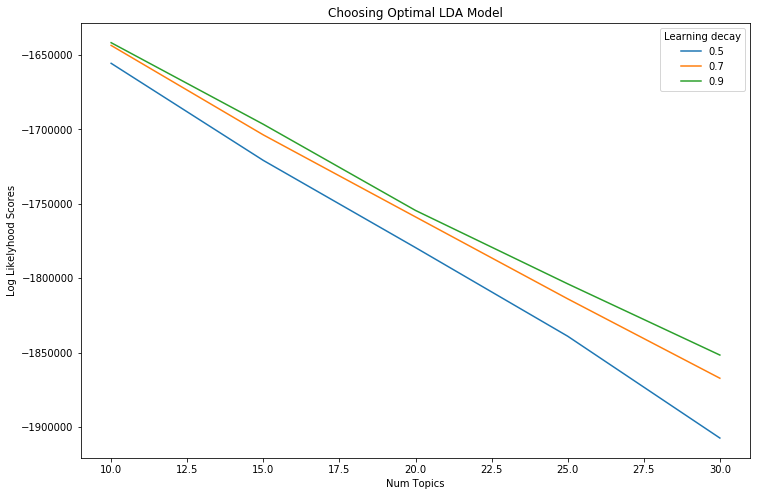

In [27]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [29]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.03,0.03,0.03,0.03,0.03,0.03,0.52,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,6
Doc1,0.19,0,0,0,0.4,0,0,0,0,0,0.07,0,0,0.29,0,0,0,0,0,0,4
Doc2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.01,0.12,0.01,0.01,0.01,0.01,0.01,0.01,9
Doc3,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0.84,0,0,0,0,0,0,13
Doc4,0,0,0,0,0,0,0,0,0,0.1,0,0,0,0.84,0,0,0,0,0,0,13
Doc5,0,0,0,0,0,0,0,0,0,0,0,0.69,0,0.07,0,0,0.19,0,0,0,11
Doc6,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,0,0,0,0,0,7
Doc7,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,0,0,0,0,0,7
Doc8,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,0,0,0,0,0,7
Doc9,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,0,0,0,0,0,7


In [30]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,19,5372
1,9,2504
2,4,1417
3,15,1351
4,11,1182
5,3,807
6,16,718
7,10,685
8,13,634
9,1,591


In [31]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

E:\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      -22.771599   71.321510       1        1  23.286654
1      -97.794914   23.038486       2        1  12.210365
2      124.565071    0.067601       3        1  12.115343
8      -79.221649  134.060074       4        1   9.344243
9       26.896021  151.890228       5        1   9.190823
5      124.322838  113.434837       6        1   9.026155
0      -53.101768  -66.502243       7        1   7.604483
6        7.813132   -6.151612       8        1   7.333647
4       60.138775  -74.716789       9        1   6.595735
7       59.518288   58.954514      10        1   3.292553, topic_info=     Category         Freq         Term         Total  loglift  logprob
term                                                                   
5460  Default  4275.000000         tank   4275.000000  30.0000  30.0000
3293  Default  4315.000000         love   4315.000000  29.0000  29.0000
2535  Default  6488.000000        great   6488.000000  28.0000  28.0000
6120  Default  8898.000000        whale   8898.000000  27.0000  27.0000
336   Default  3050.000000         area   3050.000000  26.0000  26.0000
4820  Default  6157.000000          sea   6157.000000  25.0000  25.0000
4915  Default  7991.000000        shark   7991.000000  24.0000  24.0000
200   Default  4096.000000      amazing   4096.000000  23.0000  23.0000
2365  Default  2564.000000          fun   2564.000000  22.0000  22.0000
5582  Default  8430.000000         time   8430.000000  21.0000  21.0000
3984  Default  3174.000000      parking   3174.000000  20.0000  20.0000
2292  Default  4462.000000         food   4462.000000  19.0000  19.0000
2069  Default  5714.000000   experience   5714.000000  18.0000  18.0000
3087  Default  4207.000000          kid   4207.000000  17.0000  17.0000
1689  Default  8409.000000      dolphin   8409.000000  16.0000  16.0000
3287  Default  3333.000000          lot   3333.000000  15.0000  15.0000
2489  Default  6766.000000         good   6766.000000  14.0000  14.0000
237   Default  3777.000000       animal   3777.000000  13.0000  13.0000
2436  Default  3221.000000      georgia   3221.000000  12.0000  12.0000
5565  Default  5684.000000       ticket   5684.000000  11.0000  11.0000
3829  Default  2074.000000       online   2074.000000  10.0000  10.0000
395   Default  3213.000000      atlanta   3213.000000   9.0000   9.0000
2041  Default  7407.000000      exhibit   7407.000000   8.0000   8.0000
1465  Default  2328.000000   definitely   2328.000000   7.0000   7.0000
3229  Default  3150.000000         lion   3150.000000   6.0000   6.0000
4301  Default  3417.000000        price   3417.000000   5.0000   5.0000
2349  Default  1444.000000     friendly   1444.000000   4.0000   4.0000
5994  Default  7159.000000        visit   7159.000000   3.0000   3.0000
1410  Default  3772.000000          day   3772.000000   2.0000   2.0000
4048  Default  2320.000000      penguin   2320.000000   1.0000   1.0000
...       ...          ...          ...           ...      ...      ...
3288  Topic10   168.697609         loud    173.398981   3.3860  -4.8552
4897  Topic10    56.228630      session     57.644019   3.3886  -5.9539
3433  Topic10    95.718940       master    100.024317   3.3695  -5.4219
5369  Topic10    60.047746          sun     61.926872   3.3827  -5.8882
3030  Topic10    47.757964          jaw     48.963704   3.3886  -6.1172
3295  Topic10   145.413877       lovely    168.084433   3.2686  -5.0037
5635  Topic10   714.132290        touch   1314.725100   2.8032  -3.4122
1721  Topic10   108.281462       dragon    133.327521   3.2054  -5.2986
6028  Topic10    92.754076       waddle    113.145196   3.2148  -5.4534
555   Topic10   119.988980  beautifully    167.898823   3.0775  -5.1959
2566  Topic10   227.437479        guide    497.116616   2.6316  -4.5564
5872  Topic10    85.062508       urchin    113.519799   3.1249  -5.5399
5361  Topic10    75.1

In [33]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aah,aahhh,aback,abd,aber,abide,ability,abl,able,...,zen,zigzag,zillion,zip,zobaczenia,zone,zoo,zoolanta,zug,zum
Topic0,0.05,0.050000,0.05,0.050000,0.050001,0.05,0.050000,0.05,0.05,8.100711,...,0.05,0.050000,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05
Topic1,0.05,0.050000,0.05,0.050000,0.050000,0.05,3.948929,0.05,0.05,243.495652,...,0.05,0.050003,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05
Topic2,0.05,0.050000,0.05,0.050000,0.050000,0.05,0.050000,0.05,0.05,0.050000,...,0.05,0.050000,0.05,0.05,0.05,399.689138,0.05,0.05,0.05,0.05
Topic3,0.05,0.050000,0.05,0.050001,0.050000,0.05,0.050001,0.05,0.05,0.050000,...,0.05,0.050010,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05
Topic4,0.05,0.050005,0.05,28.528904,0.050000,0.05,0.050001,0.05,0.05,1.796546,...,0.05,5.547280,0.05,0.05,0.05,0.050000,0.05,0.05,0.05,0.05


In [34]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,gift,shop,facility,staff,exhibit,marine,wonderful,encounter,exit,child,service,young,center,money,customer
Topic 1,year,trip,old,exhibit,wait,time,line,learn,crowd,absolutely,daughter,excellent,aquarium,look,hour
Topic 2,sure,wait,minute,seat,son,early,row,line,time,wet,long,want,arrive,start,walk
Topic 3,ticket,online,buy,parking,purchase,discount,day,time,love,line,lot,close,advance,photo,website
Topic 4,sea,lion,dolphin,definitely,little,worth,expensive,experience,picture,aquarium,extra,life,feel,money,make
Topic 5,large,penguin,aquarium,otter,animal,beluga,water,small,tunnel,different,specie,visitor,view,world,creature
Topic 6,atlanta,aquarium,activity,park,attraction,downtown,overprice,buck,venue,provide,locate,glad,zoo,disappoint,structure
Topic 7,price,food,pay,expect,eat,high,worth,cafe,good,family,charge,site,cost,restaurant,admission
Topic 8,cool,group,feeding,hold,coral,foot,event,little,look,different,weren,toddler,location,feel,pretty
Topic 9,whale,shark,tank,aquarium,fish,ray,amazing,manta,watch,swim,huge,worth,visit,dolphin,make


In [35]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.09  0.11  0.09  0.13  0.25  0.13  0.08  0.1   0.06  0.27  0.16  0.21
   0.1   0.12  0.07  0.18  0.11  0.08  0.04  0.79]
 [-0.08 -0.09 -0.04 -0.07 -0.25 -0.15 -0.06 -0.06 -0.05 -0.54 -0.13 -0.25
  -0.1  -0.09 -0.05 -0.38 -0.09 -0.06 -0.04  0.58]]
Perc of Variance Explained: 
 [0.08 0.15]


Text(0.5,1,'Segregation of Topic Clusters')

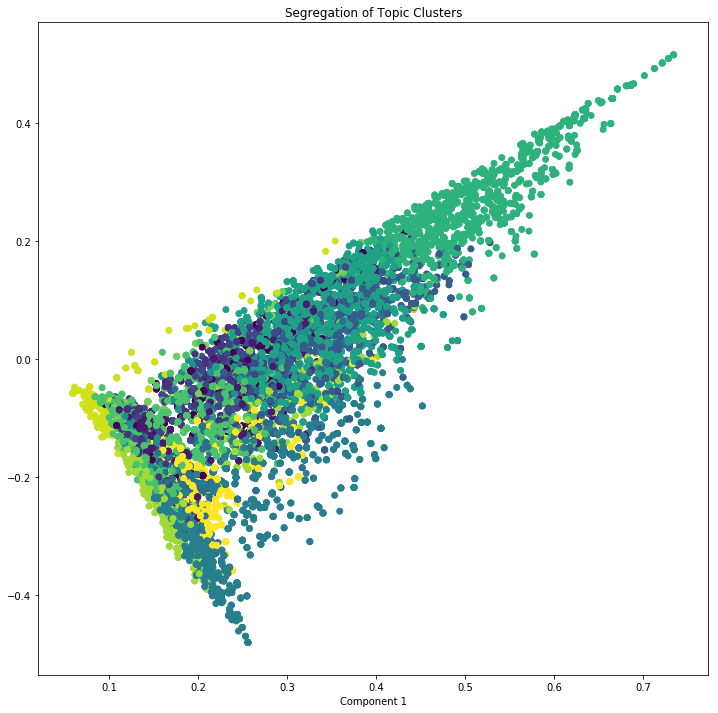

In [36]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )